# Install Dependencies and Mount Drive

In [45]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
import gc
import csv

import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Get Directories

In [31]:
train_dir = './experiment1_train_nma'
test_dir = './experiment1_test_nma'

In [32]:
# hyper-parameters
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 128
max_epochs = 15  # Please change this to 200
max_epochs_target = 10
base_learning_rate = 0.1 
torchvision_transforms = True  # True/False if you want use torchvision augmentations

# Set-Up DataLoaders

In [ ]:
# Transform Properties
batch_size = 128
learning_rate = 1e-3
data_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

# Load Data
train_dataset = datasets.ImageFolder(train_dir,data_transforms)
test_dataset = datasets.ImageFolder(test_dir,data_transforms)
# Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Show Image Inputs

In [34]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

# imshow(out, title=[train_dataset.classes[x] for x in labels])

images-size: torch.Size([128, 3, 224, 224])
out-size: torch.Size([3, 3618, 1810])


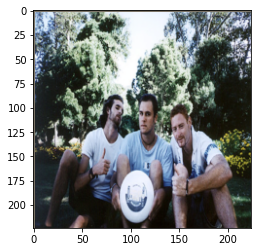

'thumbsup'

In [35]:
imshow(out[:,:224,:224])
train_dataset.classes[labels[0]]

### Transfer Learning - Resnet code

In [36]:
# @title ResNet model in PyTorch

class BasicBlock(nn.Module):
  """ResNet in PyTorch.
      Reference:
      [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
        Deep Residual Learning for Image Recognition. arXiv:1512.03385
  """

  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=13):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
  return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
  return ResNet(Bottleneck, [3, 4, 6, 3])

In [37]:


#net = models.resnet18(pretrained=True)
#net = net.cuda() if device else net
net = ResNet50()

In [47]:
# Load the Model
net = ResNet50()
print('-----> verify if model is run on random data')
y = net(Variable(torch.randn(1,3,32,32)))
print('model loaded')

result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

logname = result_folder + net.__class__.__name__ + '_pretrain' + '.csv'

if use_cuda:
  net.cuda()
  net = torch.nn.DataParallel(net)
  print('Using', torch.cuda.device_count(), 'GPUs.')
  cudnn.benchmark = True
  print('Using CUDA..')

-----> verify if model is run on random data
model loaded


In [48]:
#Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [15]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

#num_ftrs = net.fc.in_features
#net.fc = nn.Linear(num_ftrs, 128)
#net.fc = net.fc.cuda() if use_cuda else net.fc
#net.fc = net.fc.cuda() 

In [16]:
n_epochs = 3
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1



KeyboardInterrupt: 

In [49]:
# Training & Test functions

def train(net, epoch, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    if batch_idx % 500 == 0:
      print(batch_idx, len(train_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, outModelName, use_cuda=True):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(test_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
    checkpoint(net, acc, epoch, outModelName)
  return (test_loss/batch_idx, 100.*correct/total)

In [50]:
# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{outModelName}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [51]:
# Start training
outModelName = 'pretrain'
if not os.path.exists(logname):
  with open(logname, 'w') as logfile:
      logwriter = csv.writer(logfile, delimiter=',')
      logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

for epoch in range(start_epoch, max_epochs):
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(net, epoch, use_cuda=use_cuda)
  test_loss, test_acc = test(net, epoch, outModelName, use_cuda=use_cuda)
  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
  print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0


KeyboardInterrupt: 

Populating the interactive namespace from numpy and matplotlib


/Users/schonehr/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


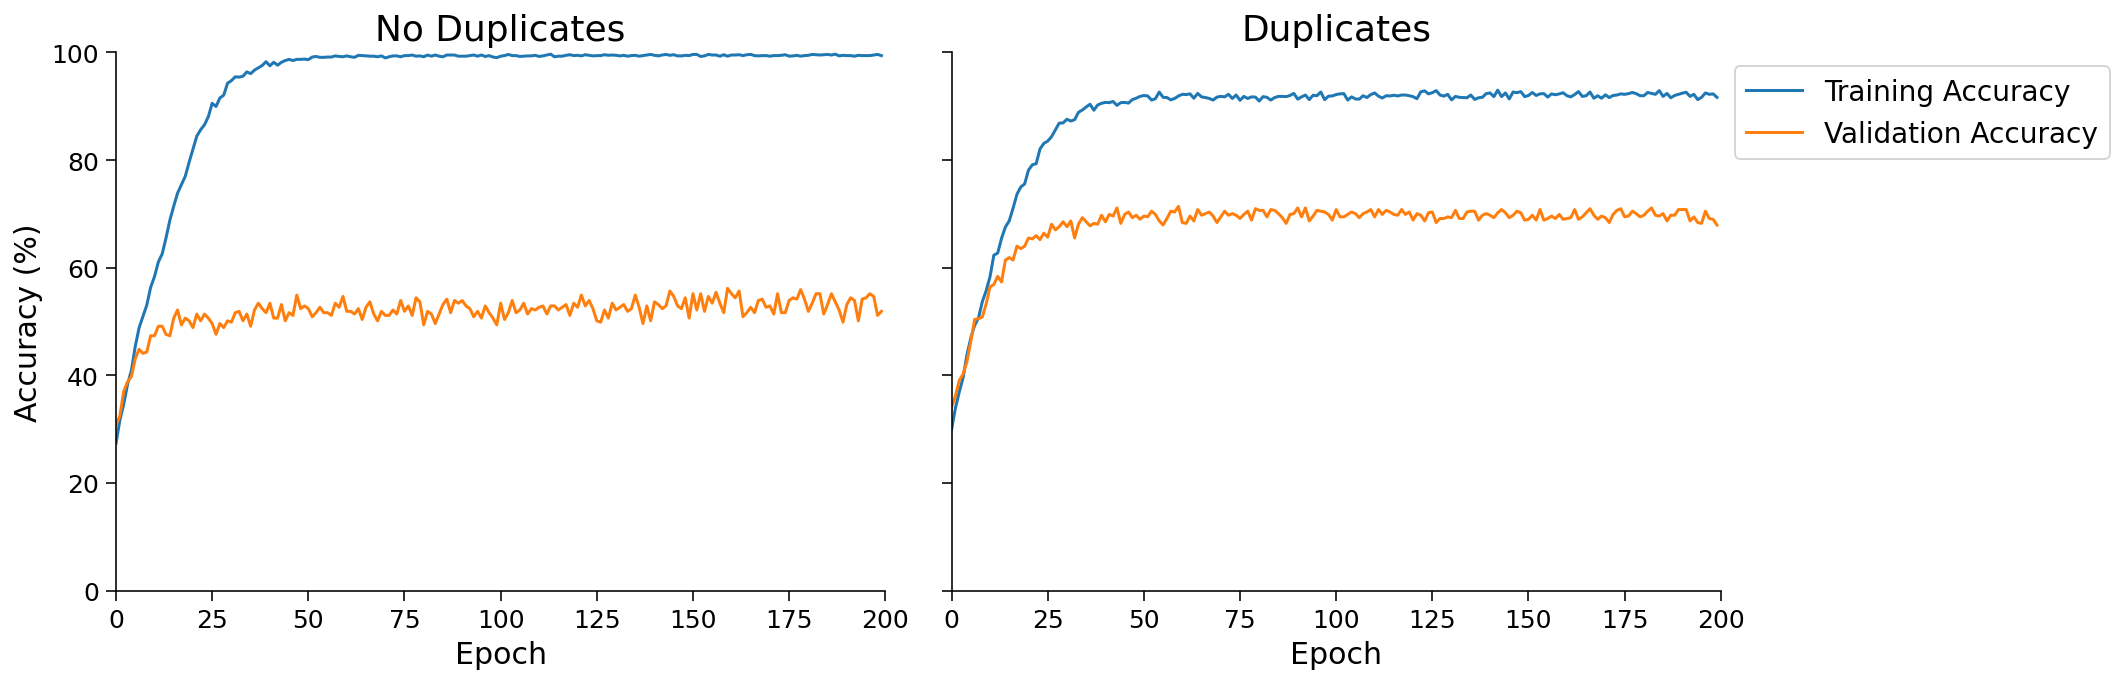

In [112]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import rcParams
%pylab inline
import seaborn as sns
import pandas as pd
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%config InlineBackend.figure_format = 'retina'

#load data
nodups = pd.read_csv('../results/experiment1_nodups_batchsize64_epochs200_result.csv')
dups = pd.read_csv('../results/experiment1_dups_batchsize64_epochs200_result.csv')

#made index the epoch column
nodups['epoch'] = nodups.index
dups['epoch'] = dups.index

# time series plot for multiple columns
fig, axes = plt.subplots(1,2,figsize=(15, 5))
ax1 = nodups.plot(x="epoch", y=["train_acc", "test_acc"],kind="line",ax=axes[0])
ax1.set_xlim(left=0, right=200)
axes[0].set_ylim(bottom=0, top=100)
ax1 = plt.ylabel("Accuracy")
ax2 = dups.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[1],sharey=ax1, sharex=ax1)
axes[0].set_xlabel('Epoch')
axes[1].set_ylim(bottom=0, top=100)
axes[1].set_xlim(left=0, right=200)
axes[1].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('Accuracy (%)')
axes[0].set_title("No Duplicates")
axes[1].set_title("Duplicates")
axes[0].get_legend().remove()
fig.set_facecolor("w")

plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=14, loc='upper left',frameon=True, bbox_to_anchor=(1.0, 1.0))

plt.savefig('../results/figures/exp1_social_interactions_dups_vs_nodups.png',dpi=300,bbox_inches="tight")

Populating the interactive namespace from numpy and matplotlib


/Users/schonehr/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Social Interactions (DR: 10%, LR: 1e-3)
train_acc    93.022263
test_acc     71.255676
dtype: float64
Social Interactions (DR: None, LR: 1e-3)
train_acc    93.236298
test_acc     71.104385
dtype: float64
Social Interactions (DR: 10%, LR: 1e-4)
train_acc    52.140411
test_acc     55.673222
dtype: float64
Posture (DR: 10%, LR: 1e-3)
train_acc    87.322441
test_acc     24.472256
dtype: float64
Posture (DR: None, LR: 1e-3)
train_acc    89.098015
test_acc     25.286489
dtype: float64
Motion (DR: 10%, LR: 1e-3)
train_acc    63.032185
test_acc     56.855518
dtype: float64


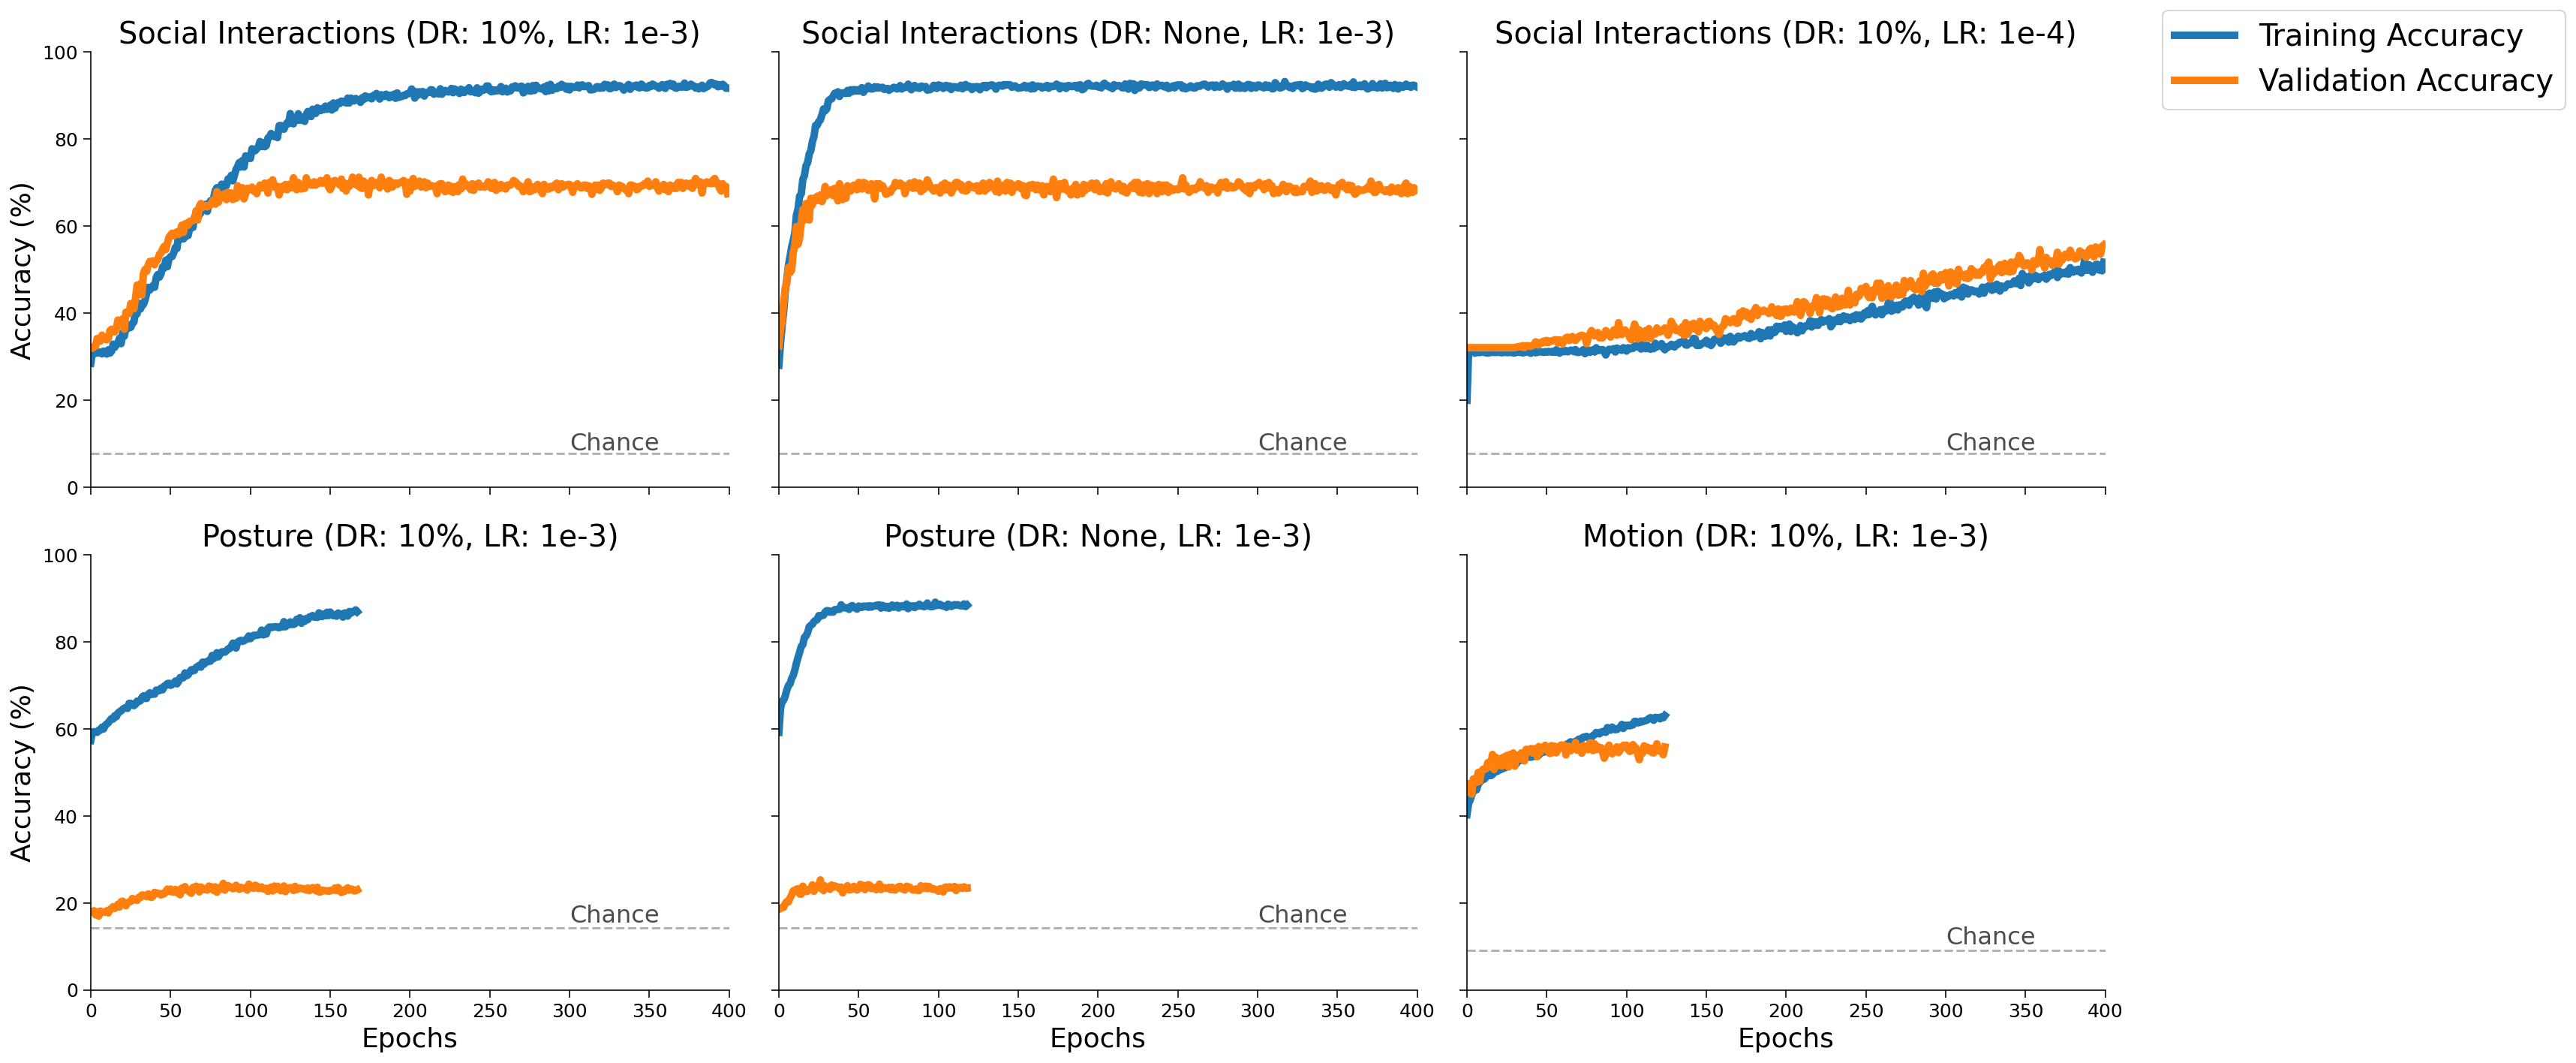

In [247]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import rcParams
%pylab inline
import seaborn as sns
import pandas as pd
from matplotlib.pyplot import text
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%config InlineBackend.figure_format = 'retina'

#load data
social_dr1_lr3 = pd.read_csv('../results/experiment1/experiment1_social-interactions_duplicates_batchsize64_lre-3_dropout0.1_epochs400_result.csv')
social_dr1_lr4 = pd.read_csv('../results/experiment1/experiment1_posture_duplicates_batchsize64_lre-4_dropout0.1_epochs400_result.csv')
social_nodr_lr3 = pd.read_csv('../results/experiment1/experiment1_social-interactions_duplicates_batchsize64_lre-3_NOdropout_epochs400_result.csv')
posture_dr1_lr3 = pd.read_csv('../results/experiment1/experiment1_posture_duplicates_batchsize64_lre-3_dropout0.1_epochs400_result.csv')
posture_nodr_lr3 = pd.read_csv('../results/experiment1/experiment1_posture_duplicates_batchsize64_lre-3_NOdropout_epochs400_result.csv')
motion_dr1_lr3 = pd.read_csv('../results/experiment1/experiment1_motion_duplicates_batchsize64_lre-3_dropout0.1_epochs400_result.csv')

maxs = social_dr1_lr3[['train_acc', 'test_acc']].max()
print('Social Interactions (DR: 10%, LR: 1e-3)')
print(maxs)
maxs = social_nodr_lr3[['train_acc', 'test_acc']].max()
print('Social Interactions (DR: None, LR: 1e-3)')
print(maxs)
maxs = social_dr1_lr4[['train_acc', 'test_acc']].max()
print('Social Interactions (DR: 10%, LR: 1e-4)')
print(maxs)
maxs = posture_dr1_lr3[['train_acc', 'test_acc']].max()
print('Posture (DR: 10%, LR: 1e-3)')
print(maxs)
maxs = posture_nodr_lr3[['train_acc', 'test_acc']].max()
print('Posture (DR: None, LR: 1e-3)')
print(maxs)
maxs = motion_dr1_lr3[['train_acc', 'test_acc']].max()
print('Motion (DR: 10%, LR: 1e-3)')
print(maxs)

# time series plot for multiple columns
fig, axes = plt.subplots(2,3,figsize=(20, 10))#,sharex='col',sharey='row')
ax1 = social_dr1_lr3.plot(x="epoch", y=["train_acc", "test_acc"],kind="line",ax=axes[0, 0],linewidth=5)
ax1.set_xlim(left=0, right=400)
axes[0,0].set_ylim(bottom=0, top=100)
axes[0,0].set_xlim(left=0, right=400)
axes[0,0].set_ylabel('Accuracy (%)',fontsize=18)
axes[0,0].set_title("Social Interactions (DR: 10%, LR: 1e-3)",fontsize=20)
axes[0,0].axhline(7.69, color='k',linestyle='--',alpha=.3)
axes[0,0].set_xlabel('Epoch',fontsize=14)
axes[0,0].get_legend().remove()
ax1.text(300,10, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax2 = social_nodr_lr3.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[0,1],sharey=ax1, sharex=ax1,linewidth=5)
axes[0,1].set_ylim(bottom=0, top=100)
axes[0,1].set_xlim(left=0, right=400)
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_ylabel('Accuracy (%)',fontsize=18)
axes[0,1].set_title("Social Interactions (DR: None, LR: 1e-3)",fontsize=20)
axes[0,1].axhline(7.69, color='k',linestyle='--',alpha=.3)
axes[0,1].get_legend().remove()
ax2.text(300,10, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax3 = social_dr1_lr4.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[0, 2],sharey=ax1, sharex=ax1,linewidth=5)
axes[0,2].set_ylim(bottom=0, top=100)
axes[0,2].set_xlim(left=0, right=400)
axes[0,2].set_xlabel('Epochs')
axes[0,2].set_ylabel('Accuracy (%)',fontsize=18)
axes[0,2].set_title("Social Interactions (DR: 10%, LR: 1e-4)",fontsize=20)
axes[0,2].axhline(7.69, color='k',linestyle='--',alpha=.3)
axes[0,2].get_legend().remove()
ax3.text(300,10, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax4 = posture_dr1_lr3.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[1, 0],sharey=ax1, sharex=ax1,linewidth=5)
axes[1,0].set_ylim(bottom=0, top=100)
axes[1,0].set_xlim(left=0, right=400)
axes[1,0].set_xlabel('Epochs',fontsize=18)
axes[1,0].set_ylabel('Accuracy (%)',fontsize=18)
axes[1,0].set_title("Posture (DR: 10%, LR: 1e-3)",fontsize=20)
axes[1,0].axhline(14.2, color='k',linestyle='--',alpha=.3)
axes[1,0].get_legend().remove()
ax4.text(300,17, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax5 = posture_nodr_lr3.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[1, 1],sharey=ax1, sharex=ax1,linewidth=5)
axes[1,1].set_ylim(bottom=0, top=100)
axes[1,1].set_xlim(left=0, right=400)
axes[1,1].set_xlabel('Epochs',fontsize=18)
axes[1,1].set_ylabel('Accuracy (%)',fontsize=18)
axes[1,1].set_title("Posture (DR: None, LR: 1e-3)",fontsize=20)
axes[1,1].axhline(14.2, color='k',linestyle='--',alpha=.3)
axes[1,1].get_legend().remove()
ax5.text(300,17, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax6 = motion_dr1_lr3.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[1,2],sharey=ax1, sharex=ax1,linewidth=5)
axes[1,2].set_ylim(bottom=0, top=100)
axes[1,2].set_xlim(left=0, right=400)
axes[1,2].set_xlabel('Epochs',fontsize=18)
axes[1,2].set_ylabel('Accuracy (%)')
axes[1,2].set_title("Motion (DR: 10%, LR: 1e-3)",fontsize=20)
axes[1,2].axhline(9.09, color='k',linestyle='--',alpha=.3)
axes[1,2].get_legend().remove()
ax6.text(300,12, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

fig.set_facecolor("w")
fig.legend(['Training Accuracy','Validation Accuracy'],fontsize=20, loc='upper left',frameon=True, bbox_to_anchor=(1.0, 1.0))

plt.savefig('../results/figures/experiment1_allmodels.png',dpi=300,bbox_inches="tight")

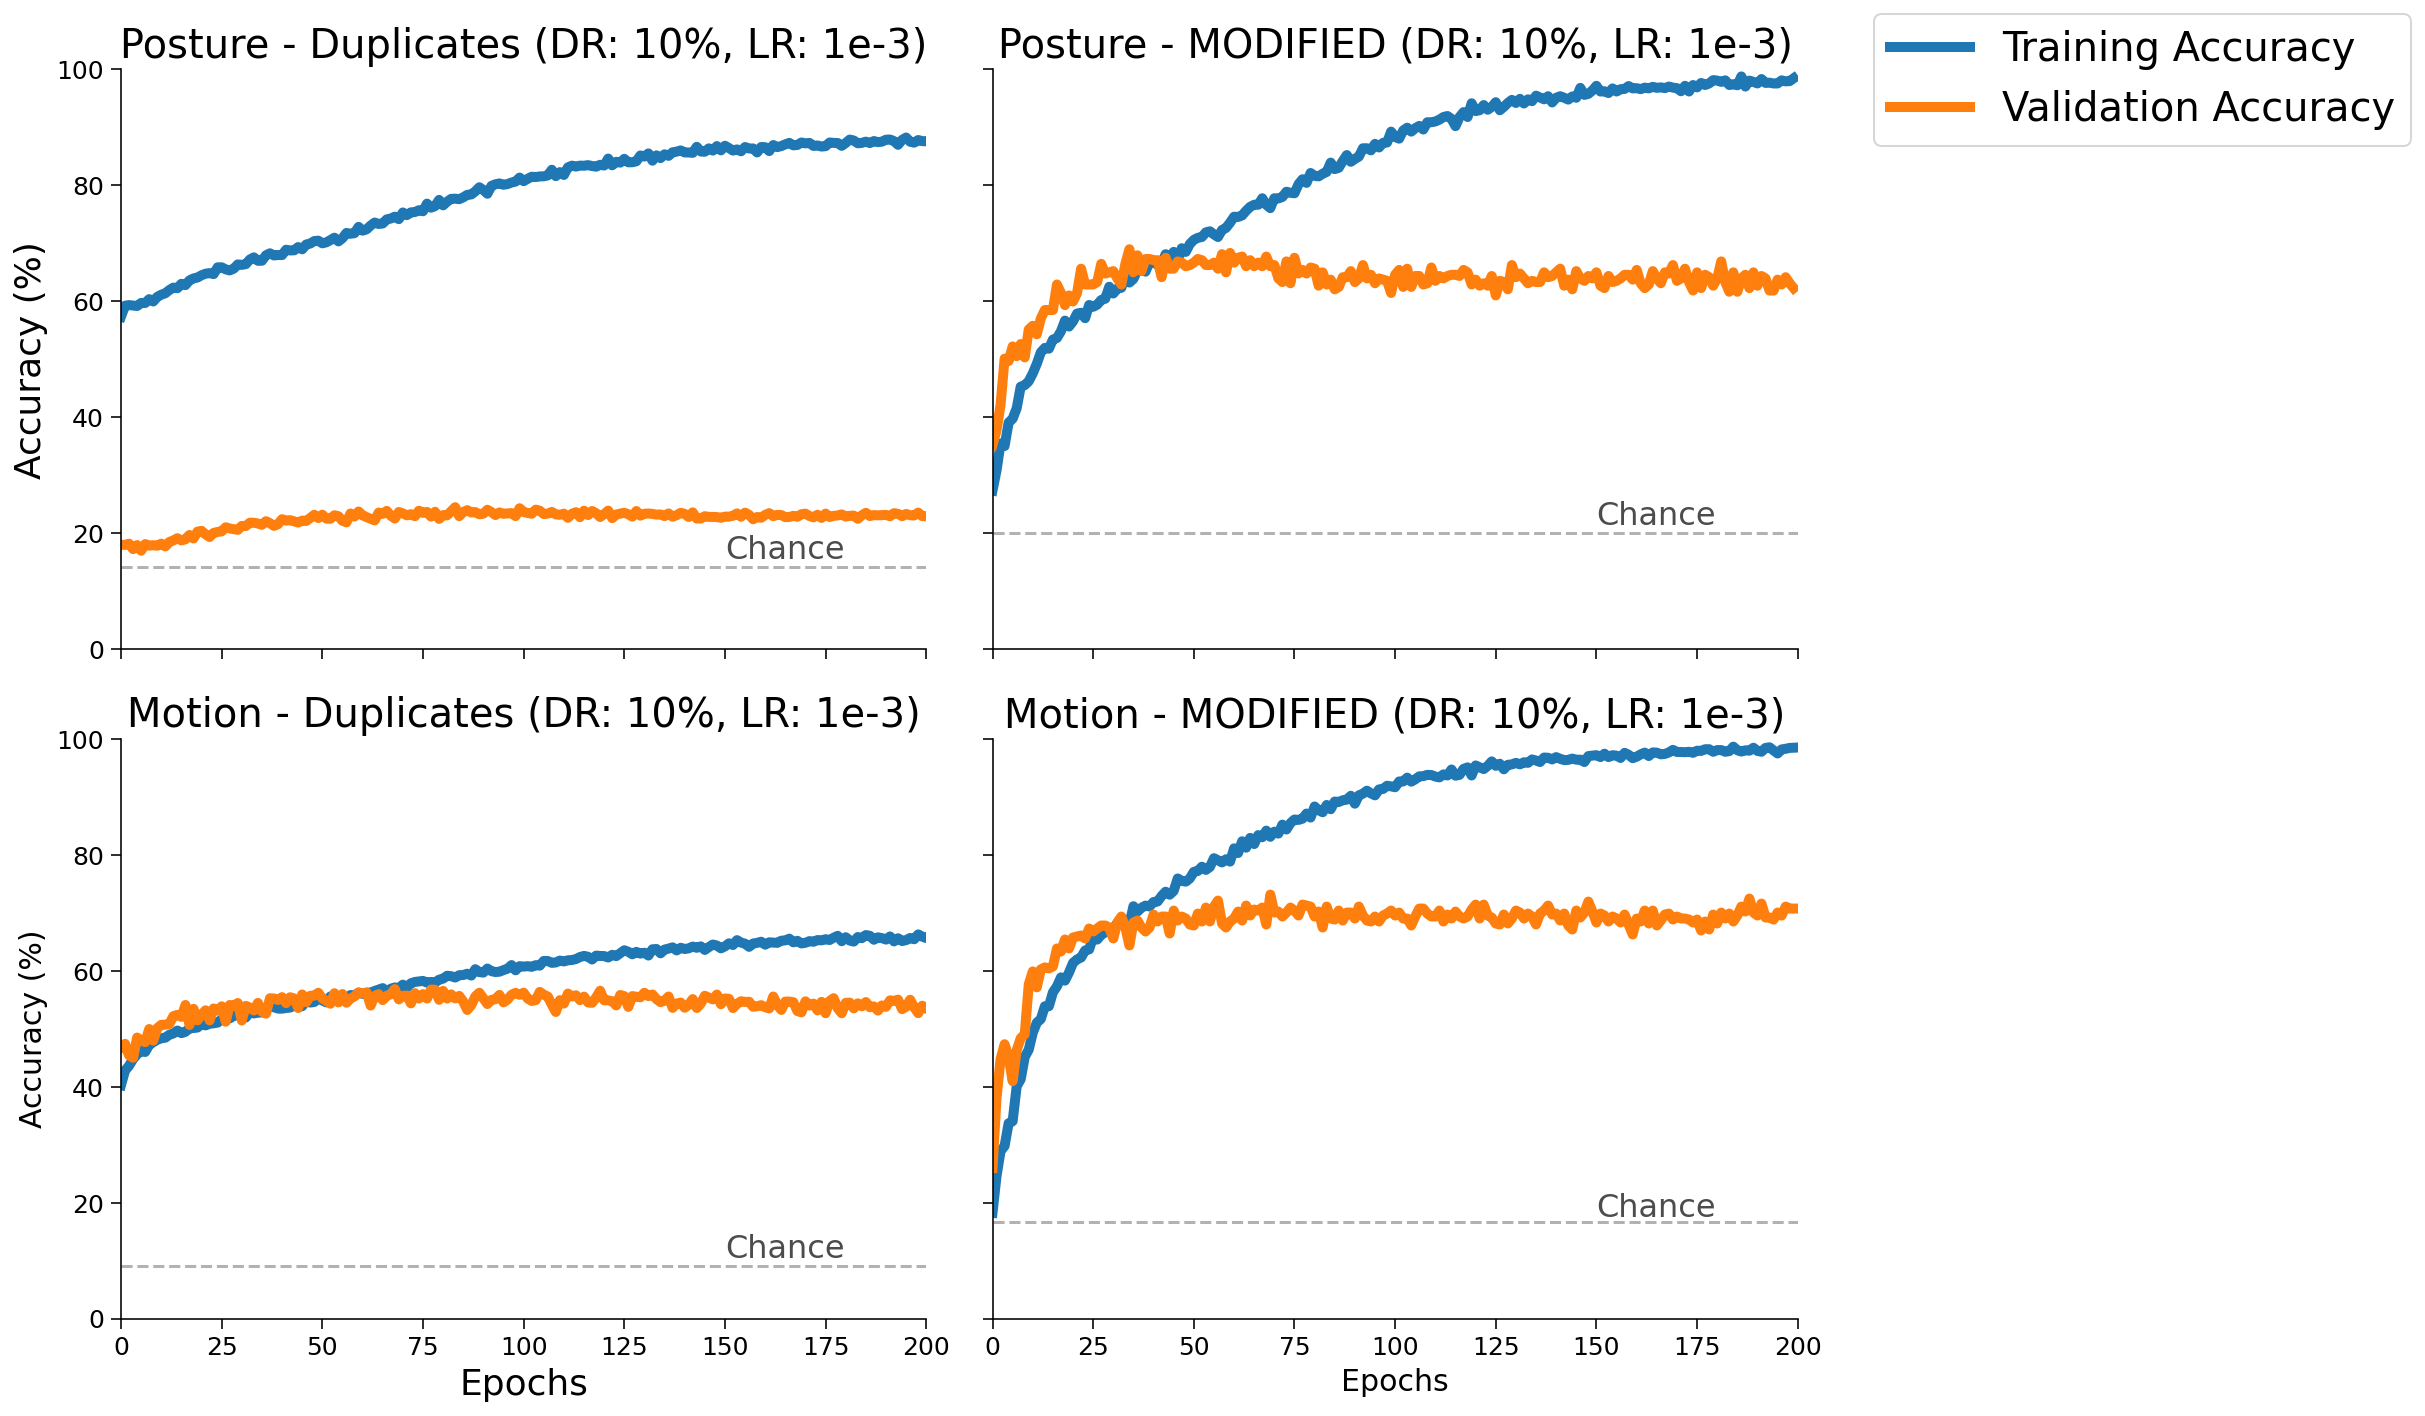

In [264]:
posture_dr1_lr3 = pd.read_csv('../results/experiment1/experiment1_posture_duplicates_batchsize64_lre-3_dropout0.1_epochs400_result.csv')
posture_dr1_lr3_nodups = pd.read_csv('../results/experiment1/run2/experiment1_posture_NOduplicates_batchsize64_lre-3_dropout0.1_epochs200_result.csv')
motion_dr1_lr3_nodups = pd.read_csv('../results/experiment1/run2/experiment1_motion_NOduplicates_batchsize64_lre-3_dropout0.1_epochs200_result.csv')
motion_dr1_lr3 = pd.read_csv('../results/experiment1/experiment1_motion_duplicates_batchsize64_lre-3_dropout0.1_epochs400_result.csv')

# time series plot for multiple columns
fig, axes = plt.subplots(2,2,figsize=(13, 10))#,sharex='col',sharey='row')

ax1 = posture_dr1_lr3.plot(x="epoch", y=["train_acc", "test_acc"],kind="line",ax=axes[0, 0],linewidth=5)
ax1.set_xlim(left=0, right=400)
axes[0,0].set_ylim(bottom=0, top=100)
axes[0,0].set_xlim(left=0, right=200)
axes[0,0].set_ylabel('Accuracy (%)',fontsize=18)
axes[0,0].set_title("Posture - Duplicates (DR: 10%, LR: 1e-3)",fontsize=20)
axes[0,0].axhline(14.2, color='k',linestyle='--',alpha=.3)
#axes[0,0].set_xlabel('Epoch',fontsize=14)
axes[0,0].get_legend().remove()
ax1.text(150,17, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax2 = posture_dr1_lr3_nodups.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[0, 1],sharey=ax1, sharex=ax1,linewidth=5)
axes[0,1].set_ylim(bottom=0, top=100)
axes[0,1].set_xlim(left=0, right=200)
axes[0,1].set_xlabel('Epochs',fontsize=18)
axes[0,1].set_ylabel('Accuracy (%)',fontsize=18)
axes[0,1].set_title("Posture - MODIFIED (DR: 10%, LR: 1e-3)",fontsize=20)
axes[0,1].axhline(20, color='k',linestyle='--',alpha=.3)
axes[0,1].get_legend().remove()
ax2.text(150,23, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax3 = motion_dr1_lr3.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[1,0],sharey=ax1, sharex=ax1,linewidth=5)
axes[1,0].set_ylim(bottom=0, top=100)
axes[1,0].set_xlim(left=0, right=200)
axes[1,0].set_xlabel('Epochs',fontsize=18)
axes[1,0].set_ylabel('Accuracy (%)')
axes[1,0].set_title("Motion - Duplicates (DR: 10%, LR: 1e-3)",fontsize=20)
axes[1,0].axhline(9.09, color='k',linestyle='--',alpha=.3)
axes[1,0].get_legend().remove()
ax3.text(150,12, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

ax4 = motion_dr1_lr3_nodups.plot(x="epoch", y=["train_acc", "test_acc"],kind="line", ax=axes[1,1],sharey=ax1, sharex=ax1,linewidth=5)
axes[1,1].set_ylim(bottom=0, top=100)
axes[1,1].set_xlim(left=0, right=200)
axes[1,1].set_xlabel('Epochs')
axes[1,1].set_ylabel('Accuracy (%)',fontsize=18)
axes[1,1].set_title("Motion - MODIFIED (DR: 10%, LR: 1e-3)",fontsize=20)
axes[1,1].axhline(16.67, color='k',linestyle='--',alpha=.3)
axes[1,1].get_legend().remove()
ax4.text(150,19, "Chance", rotation=0, verticalalignment='center',color='k',alpha=.7,fontsize=16)

fig.set_facecolor("w")
fig.legend(['Training Accuracy','Validation Accuracy'],fontsize=20, loc='upper left',frameon=True, bbox_to_anchor=(1.0, 1.0))

plt.savefig('../results/figures/experiment1_modified_posture_motion.png',dpi=300,bbox_inches="tight")

In [279]:
posture = pd.read_csv('../results/experiment1/experiment1_posture_NOduplicates_batchsize64_lre-3_dropout0.1_epochs200_result.csv')
motion = pd.read_csv('../results/experiment1/experiment1_motion_NOduplicates_batchsize64_lre-3_dropout0.1_epochs200_result.csv')
social = pd.read_csv('../results/experiment1/experiment1_social-interactions_duplicates_batchsize64_lre-3_dropout0.1_epochs400_result.csv')

# time series plot for multiple columns
#fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13, 10),sharey='row')#,sharex='col',sharey='row')

motion_labels = motion['train_acc', 'test_acc']
posture_labels = posture['train_acc', 'test_acc']
social_labels = social["train_acc", "test_acc"]

#posture.plot(x="epoch", y=["train_acc", "test_acc"],kind="line",linewidth=5)
#motion.plot(x="epoch", y=["train_acc", "test_acc"],kind="line",linewidth=5)
#social.plot(x="epoch", y=["train_acc", "test_acc"],kind="line",linewidth=5)

plt.plot(data_1, label="Random Data")
plt.plot(data_2, data_1, label="Random Data")


KeyError: ('train_acc', 'test_acc')